# Taxi New York

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from geopy import distance
import os
from sklearn.model_selection import cross_val_score
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



## Data loading

In [2]:
#train = pd.read_csv("./input/nyc-taxi-trip-duration/train.csv")
#test = pd.read_csv("./input/nyc-taxi-trip-duration/test.csv")
#sample = pd.read_csv("./input/nyc-taxi-trip-duration/sample_submission.csv")
import os
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
#sample = pd.read_csv("../input/sample_submission.csv")

## data exploration

In [3]:
train.shape,test.shape

((1458644, 11), (625134, 9))

In [4]:
train.head(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225


In [5]:
test.head(10)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N
5,id0668992,1,2016-06-30 23:59:30,1,-73.991302,40.749798,-73.980515,40.786549,N
6,id1765014,1,2016-06-30 23:59:15,1,-73.978310,40.741550,-73.952072,40.717003,N
7,id0898117,1,2016-06-30 23:59:09,2,-74.012711,40.701527,-73.986481,40.719509,N
8,id3905224,2,2016-06-30 23:58:55,2,-73.992332,40.730511,-73.875618,40.875214,N
9,id1543102,2,2016-06-30 23:58:46,1,-73.993179,40.748760,-73.979309,40.761311,N


In [6]:
test.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000
mean,1.534884,1.661765,-73.973614,40.750927,-73.973458,40.751816
std,0.498782,1.311293,0.073389,0.029848,0.072565,0.035824
min,1.000000,0.000000,-121.933128,37.389587,-121.933327,36.601322
25%,1.000000,1.000000,-73.991852,40.737392,-73.991318,40.736000
50%,2.000000,1.000000,-73.981743,40.754093,-73.979774,40.754543
75%,2.000000,2.000000,-73.967400,40.768394,-73.963013,40.769852
max,2.000000,9.000000,-69.248917,42.814938,-67.496796,48.857597


In [7]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [8]:
train.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [9]:
test.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64

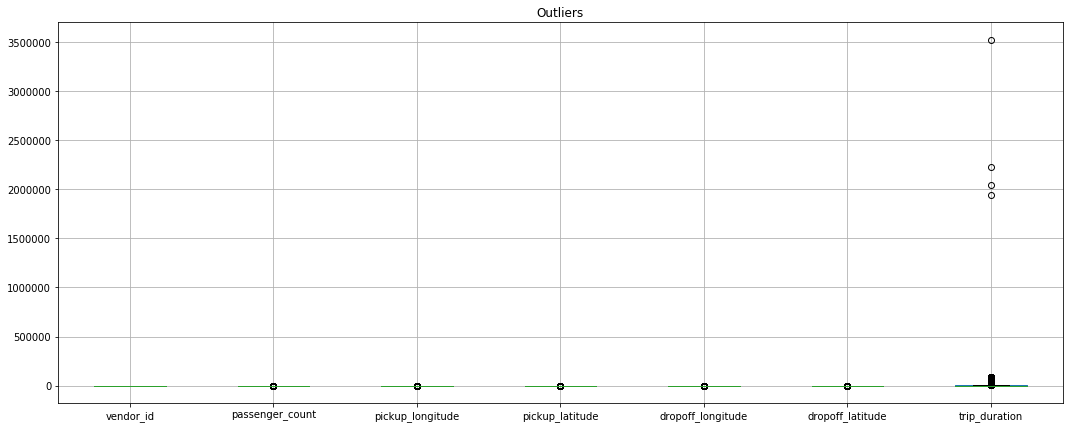

In [10]:
plt.subplots(figsize=(18,7))
plt.title("Outliers")
train.boxplot()

## data cleaning

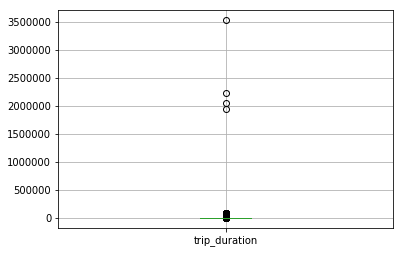

In [11]:
train[['trip_duration']].boxplot()

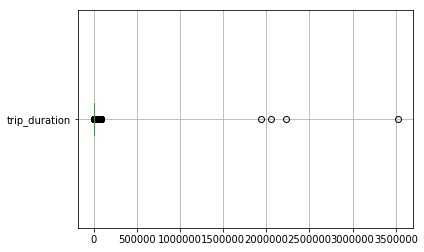

In [12]:
train[['trip_duration']].boxplot(vert=False)

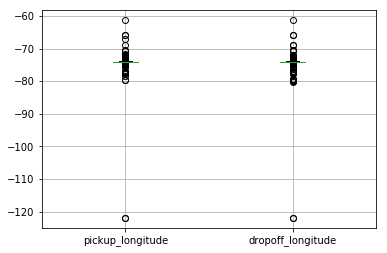

In [13]:
train[['pickup_longitude','dropoff_longitude']].boxplot()

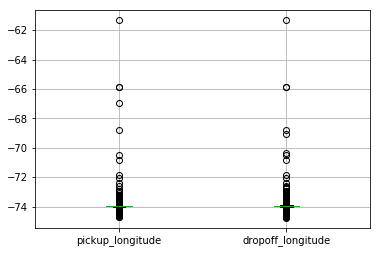

In [14]:
train = train.loc[train['dropoff_longitude']> -75]
train = train.loc[train['pickup_longitude']> -75]
train[['pickup_longitude','dropoff_longitude']].boxplot()

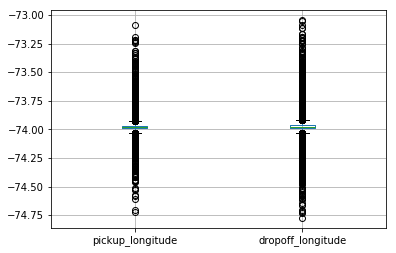

In [15]:
train = train.loc[train['dropoff_longitude']< -73]
train = train.loc[train['pickup_longitude']< -73]
train[['pickup_longitude','dropoff_longitude']].boxplot()

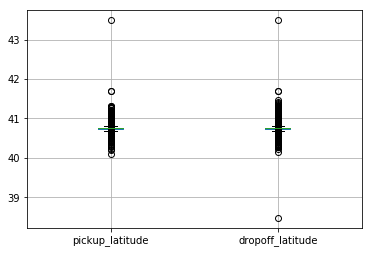

In [16]:
train[['pickup_latitude','dropoff_latitude']].boxplot()

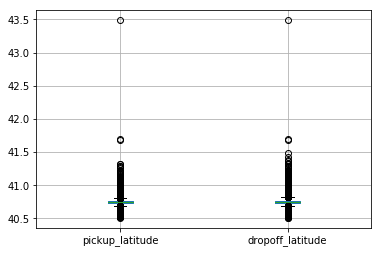

In [17]:
train = train.loc[train['dropoff_latitude']>40.5]
train = train.loc[train['pickup_latitude']>40.5]
train[['pickup_latitude','dropoff_latitude']].boxplot()

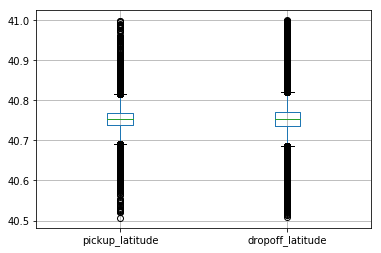

In [18]:
train = train.loc[train['dropoff_latitude']<41]
train = train.loc[train['pickup_latitude']<41]
train[['pickup_latitude','dropoff_latitude']].boxplot()

## Make more data

### Creat column for Day of the week, minute, hour, day and month

In [19]:
train['pickup_datetime']= pd.to_datetime(train.pickup_datetime, format='%Y-%m-%d %H:%M:%S')
train['day_of_the_date']=train.pickup_datetime.dt.dayofweek
train['month'] = train.pickup_datetime.dt.month
train['day'] = train.pickup_datetime.dt.day
train['hour'] = train.pickup_datetime.dt.hour
train['minute'] = train.pickup_datetime.dt.minute
train.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,day_of_the_date,month,day,hour,minute
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0,3,14,17,24
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,6,12,0,43
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,1,19,11,35
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2,4,6,19,32
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,5,3,26,13,30


In [20]:
test['pickup_datetime']= pd.to_datetime(test.pickup_datetime, format='%Y-%m-%d %H:%M:%S')
test['day_of_the_date']=test.pickup_datetime.dt.dayofweek
test['month'] = test.pickup_datetime.dt.month
test['day'] = test.pickup_datetime.dt.day
test['hour'] = test.pickup_datetime.dt.hour
test['minute'] = test.pickup_datetime.dt.minute
test.head(5)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day_of_the_date,month,day,hour,minute
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,3,6,30,23,59
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,3,6,30,23,59
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,3,6,30,23,59
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,3,6,30,23,59
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,3,6,30,23,59


### Calculate the distance between pickup point and dropoff point

In [21]:
def distancer(row):
    coords_1 = (row['pickup_latitude'], row['pickup_longitude'])
    coords_2 = (row['dropoff_latitude'], row['dropoff_longitude'])
    return distance.distance(coords_1, coords_2).km

train['distance'] = train.apply(distancer, axis=1)
test['distance'] = test.apply(distancer, axis=1)

In [22]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,day_of_the_date,month,day,hour,minute,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0,3,14,17,24,1.502172
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,6,12,0,43,1.808660
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,1,19,11,35,6.379687
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2,4,6,19,32,1.483632
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,5,3,26,13,30,1.187038


In [23]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day_of_the_date,month,day,hour,minute,distance
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,3,6,30,23,59,2.742863
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,3,6,30,23,59,2.755774
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,3,6,30,23,59,1.307112
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,3,6,30,23,59,5.266978
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,3,6,30,23,59,0.961745


## Log trip duration

(array([3.30000e+01, 0.00000e+00, 1.77000e+02, 3.15000e+02, 3.16000e+02,
        4.74000e+02, 4.22000e+02, 5.84000e+02, 6.36000e+02, 6.76000e+02,
        8.82000e+02, 1.19000e+03, 1.58300e+03, 2.83500e+03, 6.27900e+03,
        1.40250e+04, 3.13570e+04, 6.24030e+04, 1.07660e+05, 1.60303e+05,
        2.10515e+05, 2.35601e+05, 2.24935e+05, 1.79055e+05, 1.15465e+05,
        5.91630e+04, 2.68070e+04, 9.84900e+03, 2.32700e+03, 2.92000e+02,
        5.40000e+01, 2.90000e+01, 1.20000e+01, 2.30000e+01, 3.70000e+01,
        2.20000e+01, 4.30000e+01, 1.93000e+03, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 3.00000e+00, 1.00000e+00]),
 array([ 0.        ,  0.30151509,  0.60303018,  0.90454528,  1.20606037,
         1.50757546,  1.80909055,  2.11060565,  2.41212074,  2.71363583,
         3.01515092,  3.31666602,  3.61818111,  3.9196962 ,  4.22121129,
         4.52272638,  4.82424148,  5.12575657,  5

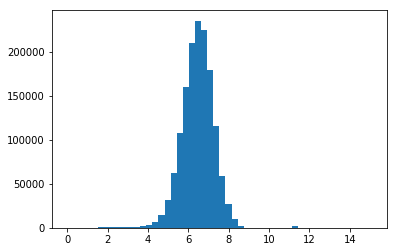

In [24]:
train['trip_duration_log']=np.log(train['trip_duration'].values)
plt.hist(train['trip_duration_log'],bins=50)

## Features selection

In [25]:
train.columns,test.columns

(Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
        'passenger_count', 'pickup_longitude', 'pickup_latitude',
        'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
        'trip_duration', 'day_of_the_date', 'month', 'day', 'hour', 'minute',
        'distance', 'trip_duration_log'],
       dtype='object'),
 Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
        'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
        'dropoff_latitude', 'store_and_fwd_flag', 'day_of_the_date', 'month',
        'day', 'hour', 'minute', 'distance'],
       dtype='object'))

In [26]:
input_columns=['day_of_the_date', 'month', 'day', 'hour','distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
y=train['trip_duration_log']
X=train[input_columns]
X_test=test[input_columns]

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2, random_state=42)

In [28]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1166650, 9), (291663, 9), (1166650,), (291663,))

## Entrainement

In [29]:
# n_estimators=19, min_samples_split=2, min_samples_leaf=4, max_features='auto', bootstrap=True, verbose=2
rfr = RandomForestRegressor(n_estimators=100,min_samples_leaf=3, min_samples_split=15, n_jobs=-1, max_features="auto")
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=15,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [30]:
cv_scores = cross_val_score(rfr, X_train, y_train, cv=5)
for i in range (len (cv_scores)):
    cv_scores[i]=np.sqrt(abs(cv_scores[i]))
print(np.mean(cv_scores))

0.8599215390616995


## Submission

In [31]:
train_pred=rfr.predict(X_test)
train_pred

array([6.6281907 , 6.36417657, 6.06775274, ..., 7.24176578, 7.55485591,
       6.95296977])

In [32]:
len(train_pred)

625134

In [33]:
my_submission = pd.DataFrame({'id':test.id, 'trip_duration':np.exp(train_pred)})

In [34]:
my_submission.to_csv('sub.csv',index=False)